# Import Dependencies

In [1]:
#pip install xgboost

In [2]:
# GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CUSTOM PLOTTING
from binary_class_plotting import get_dataset_metrics, plot_metrics

# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

# BALANCING
from imblearn.over_sampling  import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler 

# ML MODELS
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier as gbc
from xgboost import XGBClassifier as xgb
import lightgbm as lgb

# METRICS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# HYPERPARAMETER TUNNING


# Import Dataset

In [3]:
transactions_path='../MATERIALS/DATA/processed_data/transaction_data.csv'
compressed_path  ='../MATERIALS/DATA/processed_data/processed_dataset2.csv'

transactions=pd.read_csv(transactions_path)
compressed  =pd.read_csv(compressed_path) 

# Train Test Split

Will only used compressed data

In [4]:
X=compressed.copy()
y=X.target
X.drop(['ID','target'], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Data Balancing

Text(0, 0.5, 'Frequency')

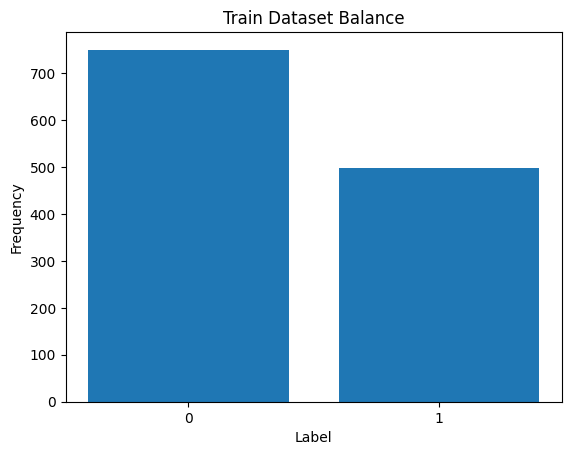

In [5]:
[counts, _]=np.histogram(y_train, bins=[0, 1, 2])
plt.bar(['0', '1'], counts)

plt.title('Train Dataset Balance')
plt.xlabel('Label')
plt.ylabel('Frequency')

In [6]:
ros  = RandomOverSampler(random_state=0)
rus  = RandomUnderSampler(random_state=0)
smote= SMOTE(random_state=0)

X_train_SMOTE, y_train_SMOTE=smote.fit_resample(X_train, y_train)
X_train_OVER , y_train_OVER =ros.fit_resample(X_train, y_train)
X_train_UNDER, y_train_UNDER=rus.fit_resample(X_train, y_train)

In [7]:
datasets={'Unbalanced':[X_train, y_train],
          'SMOTE':[X_train_SMOTE, y_train_SMOTE],
          'OVER':[X_train_OVER, y_train_OVER],
          'UNDER':[X_train_UNDER, y_train_UNDER]}

# KNN

In [8]:
neighbours         = [1, 3, 5, 10, 20, 50, 100]
f1_scores_dataset  = dict()

for dataset in datasets:
    f1_scores=list()
    [X, y]=datasets[dataset]
    
    for k in neighbours:
        knn = KNN(n_neighbors=k)
        knn.fit(X, y)

        pred=knn.predict(X_test)
        f1_scores.append(f1_score(y_test, pred))
        
    f1_scores_dataset[dataset]=f1_scores

Text(0.5, 1.0, 'KNN')

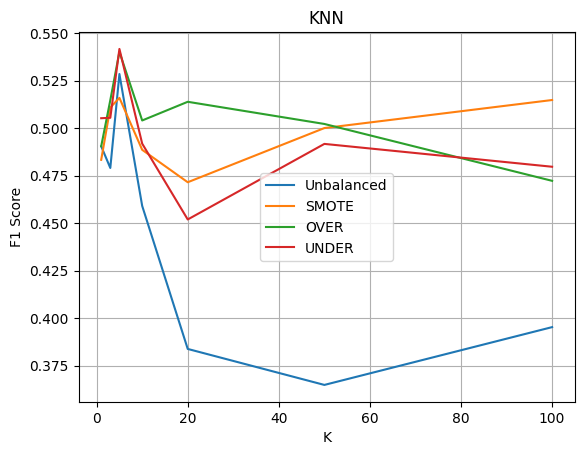

In [9]:
for dataset in datasets:
    plt.plot(neighbours, f1_scores_dataset[dataset], label=dataset)

plt.grid()

plt.legend()
plt.xlabel('K')
plt.ylabel('F1 Score')
plt.title('KNN')

Best F1 score is for K=50

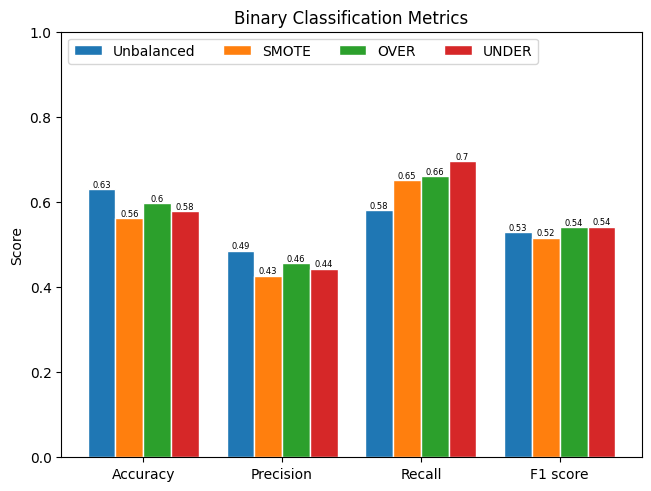

In [22]:
k    =5      # BEST F1 ACHIEVED WITH THIS K
preds=dict()

for dataset in datasets:
    [X, y]=datasets[dataset]
    
    knn = KNN(n_neighbors=k)
    knn.fit(X, y)

    preds[dataset]=knn.predict(X_test)
    
dataset_metrics=get_dataset_metrics(y_test, preds, preds.keys())
plot_metrics(dataset_metrics)

# Naïve Bayes

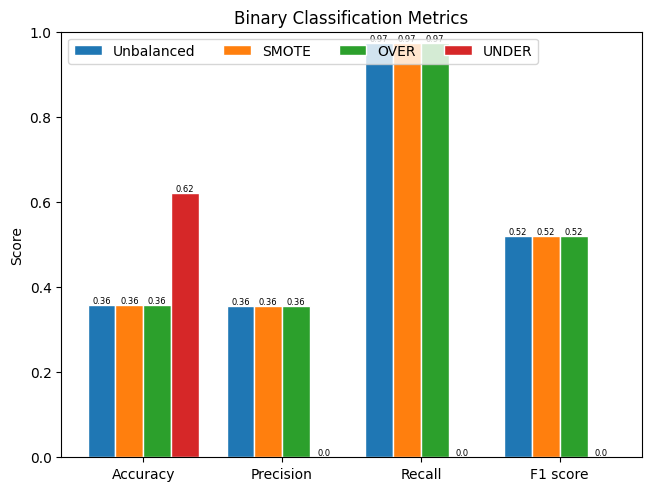

In [11]:
preds=dict()
for dataset in datasets:
    [X, y]=datasets[dataset]
    
    gnb = GaussianNB()
    gnb.fit(X, y)

    preds[dataset]=gnb.predict(X_test)
    
dataset_metrics=get_dataset_metrics(y_test, preds, preds.keys())
plot_metrics(dataset_metrics)

Not an appropriate model. Classifies everything as 1

# Decision Tree

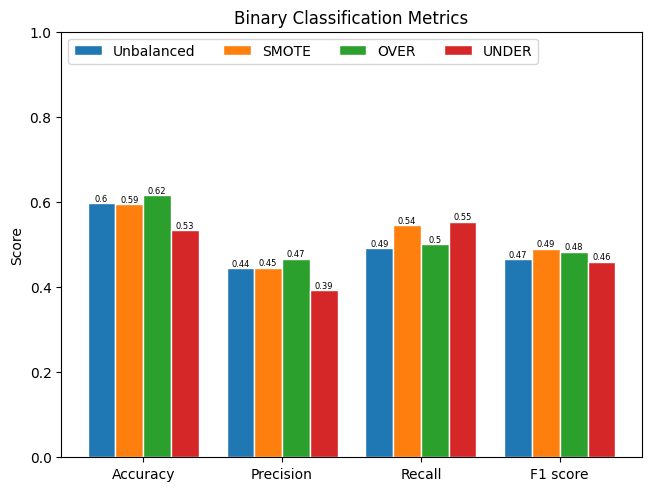

In [12]:
preds=dict()
for dataset in datasets:
    [X, y]=datasets[dataset]
    
    clf = tree.DecisionTreeClassifier()
    diagram = clf.fit(X, y)

    preds[dataset]=clf.predict(X_test)
    
dataset_metrics=get_dataset_metrics(y_test, preds, preds.keys())
plot_metrics(dataset_metrics)

# Gradient Boosting

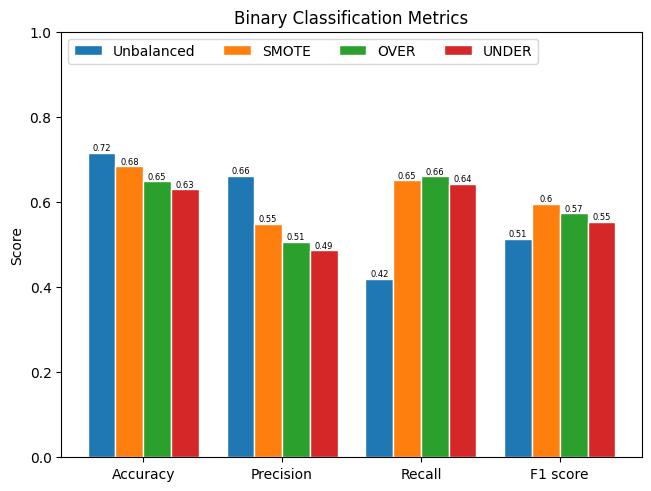

In [13]:
preds=dict()
for dataset in datasets:
    [X, y]=datasets[dataset]
    
    clf = gbc(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42).fit(X, y)

    preds[dataset]=clf.predict(X_test)
    
dataset_metrics=get_dataset_metrics(y_test, preds, preds.keys())
plot_metrics(dataset_metrics)

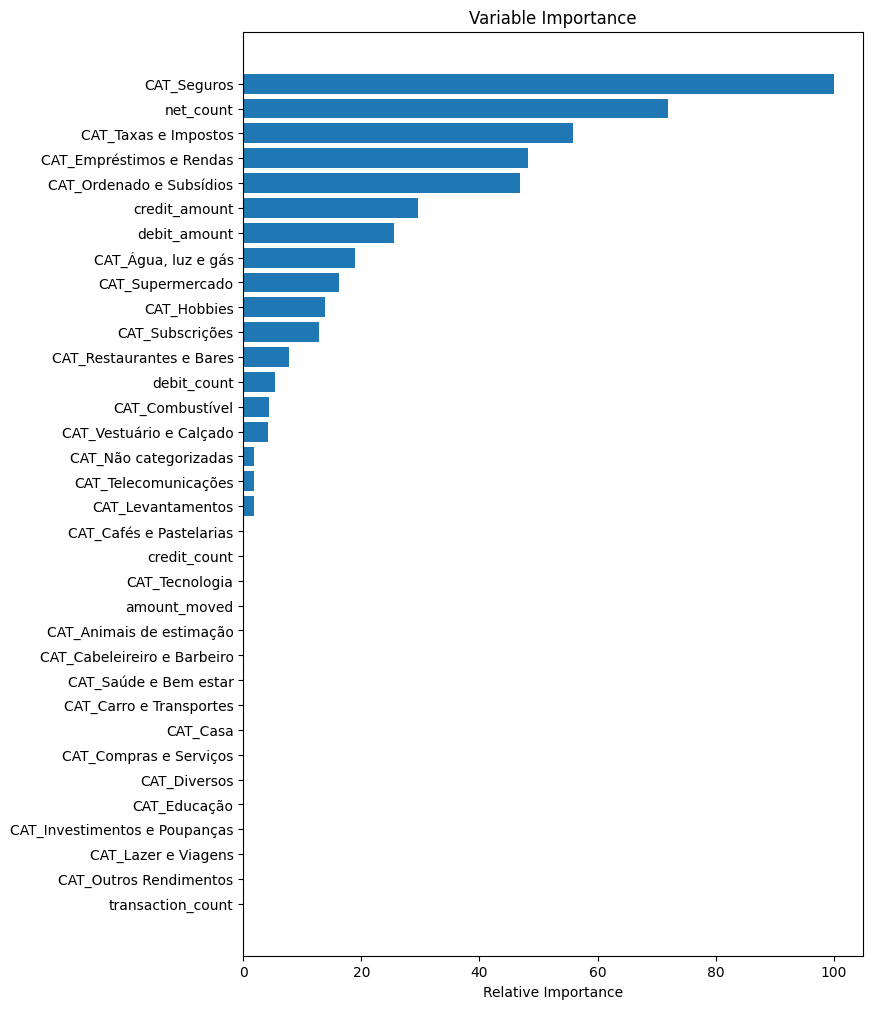

In [14]:
# Plot feature importance https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# HYPERPARAMETER TUNNING - WORK IN PROGRESS

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

https://www.aboutdatablog.com/post/learn-how-to-use-grid-search-for-parameter-tunning

### GRADIENT BOOSTING - MODEL WINNER

In [15]:
from time import time
from pandas import DataFrame

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#ACTUALLY USING GRID SEARCH. BAYESIAN IS BETTER THO

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'macro'),
           'recall': make_scorer(recall_score, average = 'macro'),
           'f1': make_scorer(f1_score, average = 'macro')}

def tune_with_halving_grid_search(x_train, y_train, param_grid):
    clf = xgb()

    start = time()
    halving_gs_results = GridSearchCV(
        clf,
        param_grid,
        cv=5,
        #factor=3,
        #min_resources='exhaust',
        scoring = scoring, 
        refit='f1'              # CHOOSE SCORING!!!!!!
    ).fit(x_train, y_train)

    duration = time() - start

    results = DataFrame(halving_gs_results.cv_results_)
    results.to_csv('tunning_results.csv')

    # take the most relevant columns and sort (for readability). Remember to sort on the iter columns first, so we see
    # the models with the most training data behind them first.
    
    #results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    #results = results.loc[:, ('rank_test_score', 'mean_test_score', 'params')]
    #results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)
    results.sort_values(by=['rank_test_f1'], ascending=[True], inplace=True)

    return results, duration

In [17]:
param_grid = {
        'n_estimators': [80, 90, 100, 110, 130, 150],
        'learning_rate': [0.2, 0.3, 0.5],
        'max_depth': [1, 2],
        'random_state': [42]
}

In [18]:
X_best = X_train_UNDER
y_best = y_train_UNDER

halving_results, halving_duration=tune_with_halving_grid_search(X_best, y_best, param_grid)

In [19]:
score  = halving_results['mean_test_f1'].iloc[0]
params = halving_results['params'].iloc[0]

print(f'Best score for HalvingGridSearchCv is {score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {params}')

Best score for HalvingGridSearchCv is 0.635, took 15.56 seconds
Params: {'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 130, 'random_state': 42}


In [20]:
clf  = xgb(**params).fit(X_best, y_best)
preds= clf.predict(X_test)

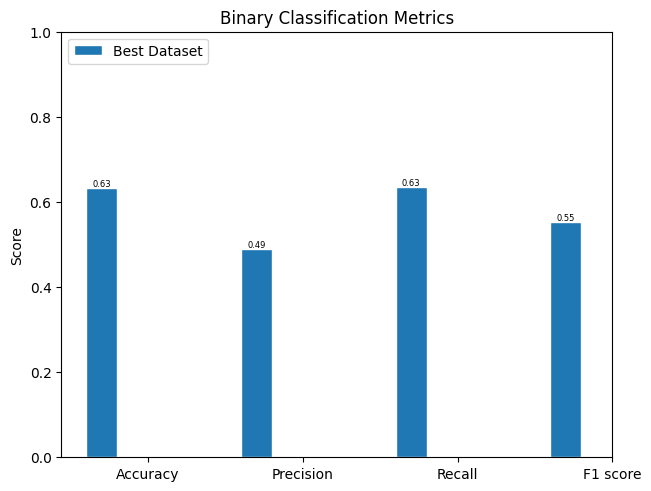

In [21]:
dataset_metrics=get_dataset_metrics(y_test, preds)
plot_metrics(dataset_metrics)